<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lecture #09

##Standard Preamble

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

##In our last episode

* How floating point numbers are represented on the computer.
 * $ X = S \times M \times 2^{E-e} $ 
* Precision and round-off error
 * If I add $x_1$ and $x_2$ with exponents $n_1>n_2$ to make a new quantity $y$ I lose the $n_1 - n_2$ bits of $x_2$ due to rounding.
 * The size of the round-off error on $y$ is $e_r = \epsilon_m x_1$ with $\epsilon_m = 2^{-24}, 2^{-53}$ for 32- and 64-bit floats.
  * Be careful adding/subtracting numbers that are not similar in size.

##Derivatives

Recall, in calculus, the derivative is defined as:

$$ \frac{\mathrm{d}f}{\mathrm{d}x} = \lim_{h \to 0} \frac{f(x+h) - f(x-h)}{2h} $$

If that limit exists, then for finite $h$ we can write:

$$ \frac{\mathrm{d}f}{\mathrm{d}x} = \frac{f(x+h) - f(x-h)}{2h} + \mathcal{O}(h^2)$$

where the $\mathcal{O}(h^2)$ is a correction proportional to $h^2$.


###Defining and testing D(f,x)

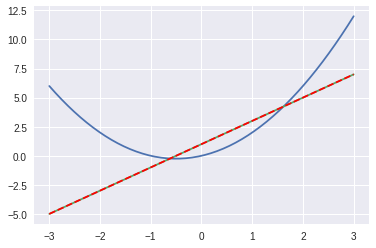

In [0]:
def D(f, x, h = 1.0e-6):
    ''' computes the derivative df/dx '''
    return (f(x+h) - f(x-h)) / (2.0*h)

f = lambda z : z + z**2
df = lambda z : 1 + 2*z # analytical derivative

x = np.linspace(-3, 3)
plt.plot(x, f(x))
plt.plot(x, df(x))
plt.plot(x, D(f,x), '--r') # numerical derivative

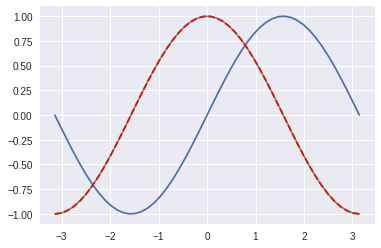

In [0]:
g = lambda z : np.sin(z)
dg = lambda z : np.cos(z) # analytical derivative

phi = np.linspace(-3.14, 3.14)
plt.plot(phi, g(phi))
plt.plot(phi, dg(phi))
plt.plot(phi, D(g,phi), '--r') # numerical derivative

###D(f,x) - df(x) and the choice of h

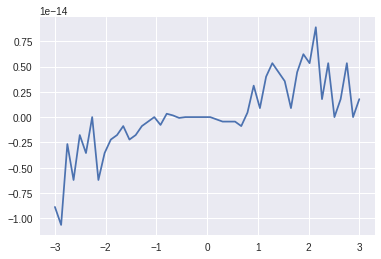

In [0]:
plt.plot(x, D(f, x, h = 1.0e-1) - df(x))

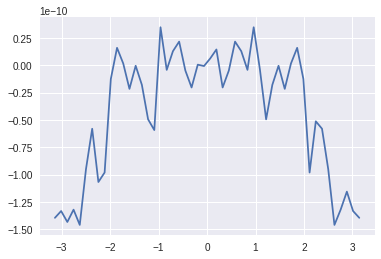

In [0]:
plt.plot(phi, D(g, phi, h = 1.0e-6) - dg(phi))

In [0]:
h = np.logspace(-1, -19, num = 19, base = 10.0)
print(h)

[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09 1.e-10
 1.e-11 1.e-12 1.e-13 1.e-14 1.e-15 1.e-16 1.e-17 1.e-18 1.e-19]


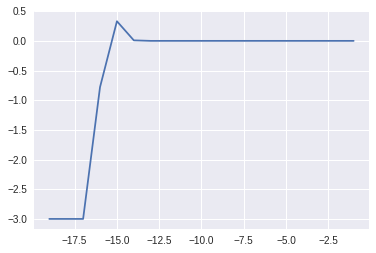

In [0]:
plt.plot(np.log10(h), D(f, 1.0, h) - df(1.0))

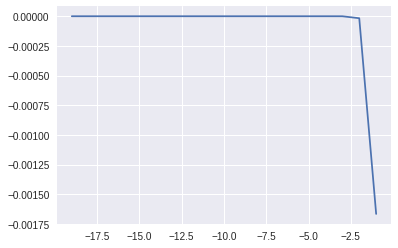

In [0]:
plt.plot(np.log10(h), D(g, 0.0, h) - dg(0.0))

###Making it more quantitative - rms vs exponent

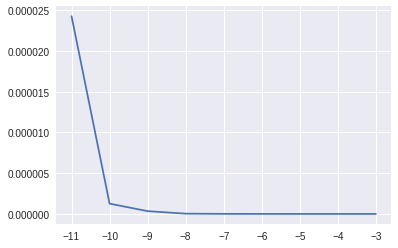

In [0]:
std_dev = []
exponents = range(-3,-12,-1)
for n in exponents:
    rms = np.std(D(f, x, h = 10.0**n) - df(x))
    std_dev.append(rms)

plt.plot(exponents, std_dev)

###Derivative of the sin() function

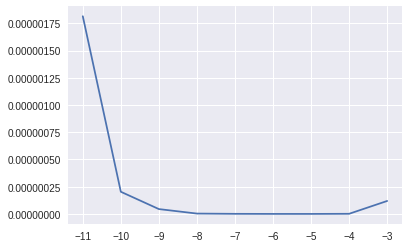

In [0]:
std_dev = []
exponents = range(-3,-12,-1)
for n in exponents:
    rms = np.std(D(g, phi, h = 10.0**n) - dg(phi))
    std_dev.append(rms)

plt.plot(exponents, std_dev)

###Picking a better h

Next time we will see how to avoid this problem with a simple trick...

##Fitting a curve to data points

###Plotting points with error bars

In [0]:
# data   Va(V), I(A), R(cm), L(cm)
raw_data=[(275, 1.30, 4.1, 3.1),
          (275, 1.20, 4.7, 3.7),
          (275, 1.10, 5.3, 4.0),
          (275, 1.40, 3.7, 3.3),
          (275, 1.50, 3.3, 2.9),
          (285, 1.50, 3.5, 2.8),
          (285, 1.40, 3.7, 3.0),
          (285, 1.30, 4.2, 3.4),
          (285, 1.20, 4.6, 3.9),
          (285, 1.10, 4.9, 4.2)]

data = np.asarray(raw_data)
V = data[::,0] # all rows, column zero
I = data[::,1]
R = data[::,2]
L = data[::,3]

#### error propagation

As you learned, or are learning, in PHYS 251, for a function $f(x)$

$$(\delta f)^2 = \left(\frac{\partial f}{\partial x}\right)^2 (\delta x)^2 $$

If $ f(x) = x^2$ then  $\delta x^2 = 2 x \delta x$ is the uncertainty of $x^2$ given an uncertainty $\delta x$ (which must be estimated by the experimenter).

We can use this to compute uncertainty arrays:

In [0]:
ER2 = 2*R*.3
EL2 = 2*L*.3
r = (R + L) / 2.0
er2 = 2*r*0.3

And then we can plot the points with errors like so:

<Container object of 3 artists>

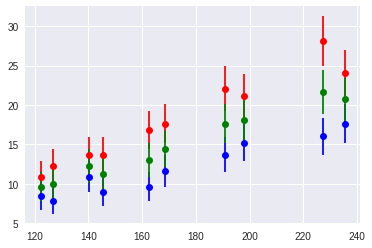

In [0]:
plt.errorbar(V / I**2, R**2, ER2, None, "or")
plt.errorbar(V / I**2, L**2, EL2, None, "ob")
plt.errorbar(V / I**2, r**2, er2, None, 'og')

### Estimators, Mean square error, Root mean square,...

Take an array of real numbers $X=\{x_i\}$ with real mean $E[X] = \bar{x}$ and real variance $Var[X] = E[(X-E[X])^2] = \sigma^2$. This could be a set of measurements of the same quantity and using the same measurement technique (so we have a constant real mean and real variance).

#### Estimating the mean
Based on the observations we want to use an __estimator for the mean__:

$$ \hat{\mu} = \frac{1}{N}\sum_{i=1}^{N} x_i$$

But, how well does this estimate do? We can consider the difference between the estimated mean $\hat{\mu}$ and the real mean $\mu$ as a random variable itself, and we can calculate its variance. That quantity is called the __mean squared error__ (MSE) of the estimator:

$$ E[(\hat{\mu} - \mu)^2] = \frac{1}{N}\sum_{i=1}^{N} (\hat{\mu}_i - \mu)^2 = Var[\hat{\mu}] + Bias[\hat{\mu},\mu]^2 $$

There are two terms: 
- a variance to indicate the estimate will not always land right on the real value, 
- a bias to allow for the estimate to not even give the real value when we repeat the experiment many times.

Of course, we would like to use unbiased estimators with $Bias[\hat{\mu},\mu] = 0$ and with a small variance $Var[\hat{\mu}]$. That is exactly what the estimator for the mean gives us, with variance

$$ Var[\hat{\mu}] = E[(\hat{\mu} - \mu)^2] = \frac{\sigma^2}{N} $$

or in other words, the uncertainty on the mean is $\sqrt{Var[\hat{\mu}]} = \sigma/\sqrt{n}$, the determination of the mean gets more precise with the square root of the number of measurements.

#### Estimating the variance
Now we can go on to building an __estimator for the variance__. You might be tempted to use an expression similar to the mean squared error above, but that would give you a _biased_ estimator for $\sigma$. Instead, the _unbiased_ estimator is:

$$ \hat{\sigma} = \frac{1}{\sqrt{N-1}} \sqrt{ \sum_{i=1}^{N} (x_i - \mu)^2 } $$

We could calculate the variance $Var[\hat{\sigma}]$ for this estimator but it is hardly ever used in practice...

#### Scientists' sloppy use of mathematics

In physics and many other sciences, you will often see the root-mean-square (RMS) denoted as $\sigma$ and used (incorrectly) as an estimator for (the square root of) the variance:

$$ RMS = \sqrt{MSE} = \frac{1}{\sqrt{N}}\sqrt{\sum_{i=1}^{N} (\bar{x} - x_i)^2 } $$

Since $\hat{\sigma}$ it is the unbiased estimator for the square root of the variance, you should use

$$ \hat{\sigma} = \frac{1}{\sqrt{N-1}} \sqrt{ \sum_{i=1}^{N} (x_i - \mu)^2 } $$

#### Finally, Python indexing...

Note that $N$ is the number of terms in the sum of squares (_i.e._ the number of data points). If your array starts at $i = 0$ and the last element has $i = n$, then the number of data points is $N = n + 1$. That, confusingly, results again in

$$ \hat{\sigma} = \frac{1}{\sqrt{N}} \sqrt{ \sum_{i=0}^{N} (x_i - \mu)^2 } $$

###Least squares fitting

Suppose I have:
* Data points $x_i,y_i,\delta y_i$ for $i=0\ldots N-1$ 
* A function $f(x,p)$ which we think describes the way $y$ depends on $x$.
  * Our theory / hypothesis. 
  * The parameters $p$ have physical meaning.
* Does our function match the data? If so, what values of parameters offer the best match?
* We need to define a distance between the $f(x_i,p)$ and $y_i$ for each point $x_i$. Consider the sum of squares:

$$ \sum_{i=0}^{N-1} (f(x_i,p) - y_i)^2 $$

* We can write a program to find the parameter values which make the sum of squares as small as possible: 
  * Method of least squares
* Good, but a bit unanchored. How close is close enough? 
* We need to incorporate the uncertainty on $y$
* Better, try to minimize
$$ \chi^2 = \sum_{i=0}^{N-1} \frac{(f(x_i,p) - y_i)^2}{(\delta y)^2} $$


Best fit is (0.107400 +/- 0.007497)*x + (-3.666924 +/- 1.171974)
chi2 = 0.8045359264323784


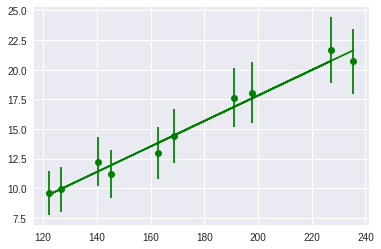

In [0]:
plt.errorbar(V/I**2, r**2, er2, None, 'og')

pars, covmx = np.polyfit(V/I**2, r**2, deg = 1, w = 1.0/er2**2, cov = True)

print("Best fit is (%f +/- %f)*x + (%f +/- %f)" % (pars[0], math.sqrt(covmx[0,0]), pars[1], math.sqrt(covmx[1,1])))

best_fit = lambda x, a = pars[1], b = pars[0]: a + b * x
plt.plot(V/I**2, best_fit(V/I**2), '-g')

chi2 = np.sum( (best_fit(V/I**2) - r**2)**2 / (er2)**2)
print("chi2 =", chi2)

In [0]:
print(covmx)
print("corr =", covmx[0,1]/math.sqrt(covmx[0,0])/math.sqrt(covmx[1,1]))

[[ 5.62102936e-05 -8.59862749e-03]
 [-8.59862749e-03  1.37352249e+00]]
corr = -0.9785957387459397


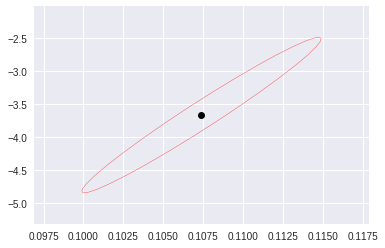

In [0]:
from matplotlib.patches import Ellipse

lambda_, v = np.linalg.eig(covmx)
lambda_ = np.sqrt(lambda_)

ax = plt.subplot(1, 1, 1)
ell = Ellipse(xy = (pars[0], pars[1]),
                    width = lambda_[0]*2,
                    height = lambda_[1]*2,
                    angle = np.rad2deg(np.arccos(v[0, 0])))
ell.set_facecolor('none')
ell.set_edgecolor('red')
ax.add_artist(ell)
plt.plot(pars[0], pars[1], 'ok')
ax.set_xlim((pars[0] - 1.4*math.sqrt(covmx[0,0]), pars[0] + 1.4*math.sqrt(covmx[0,0])))
ax.set_ylim((pars[1] - 1.4*math.sqrt(covmx[1,1]), pars[1] + 1.4*math.sqrt(covmx[1,1])))
plt.show()